"Artemis__xyz"

In [1]:
from __future__ import annotations
from typing import List
from pathlib import Path
from datetime import datetime, timezone

import pandas as pd

from scraping_kit import load_db_and_bots

path_data = Path("data")
df_accounts = pd.read_excel(path_data / "twitter_accounts.xlsx").sort_values("followersCount", ascending=False)
db_tw, bots = load_db_and_bots(path_data, "scrape_tw")

Collection Names: ['tweet_user', 'raw', 'cursors', 'trends', 'search', 'user', 'user_suspended', 'topics', 'follows']
Bots: bots=[BotScraper(acc_name='Vera')]


In [2]:
MAX_WORKERS = 40
N_BESTS = 40
list_screennames = df_accounts["screenName"].to_list()
date_i = datetime(2024, 1, 13, tzinfo=timezone.utc)
date_f = datetime.now(tz=timezone.utc)

In [3]:
#r = db_tw.collect_usertimeline(
#    list_screennames,
#    bots = bots,
#    max_workers = MAX_WORKERS,
#    days_to_update = 14
#)

In [4]:
users = db_tw.get_user_list(list_screennames)
users.keep_bests(N_BESTS)
users = db_tw.get_users_full_data(
    profiles = users.iter_profiles(),
    date_i = date_i,
    date_f = date_f
)

In [5]:
#from scraping_kit.db.db_twitter import wrap_check_follow
#from concurrent.futures import ThreadPoolExecutor, as_completed
#DAYS_TO_UPDATE_FOLLOW = 120     # 4 Months.
#with ThreadPoolExecutor(max_workers=MAX_WORKERS) as pool:
#    iter_futures = (pool.submit(wrap_check_follow, db_tw, bots.random_bot_2(), source, target, DAYS_TO_UPDATE_FOLLOW)
#                    for source, target in users.iter_profile_pairs())
#    n = len(users)
#    num_iters = n * (n - 1)
#    for i, future in enumerate(as_completed(iter_futures), 1):
#        is_download = future.result()
#        txt_iter = f"{i}/{num_iters}"
#        if is_download:
#            txt_iter += " | Download sucessfull."
#        else:
#            txt_iter += " | Existing link."
#        print(txt_iter)

In [6]:
from scraping_kit.graph_follow import GraphFollows, KWClusters
graph_follow = GraphFollows.from_users_db(db_tw, users, date_i, date_f)

[(0, '#666'), (1, '#E6BE37'), (2, '#ED851D'), (3, '#FF0000')]


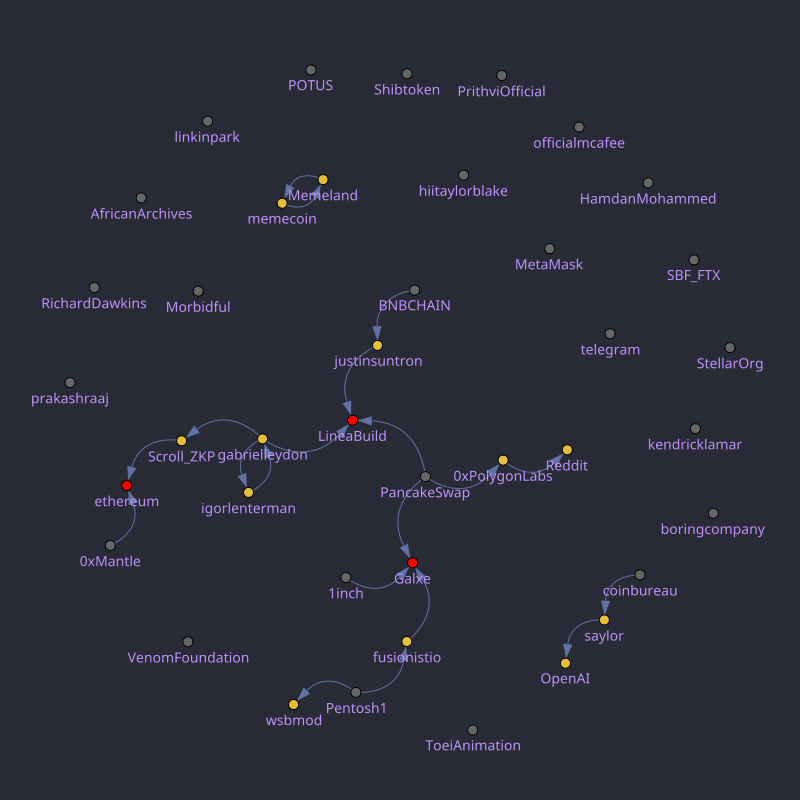

In [8]:
colors_ranges = [
    (0, "#666"),
    (1, "#E6BE37"),
    (2, "#ED851D"),
    (3, "#FF0000"),
]
cairo_plot = graph_follow.plot(with_save=False, colors_ranges=colors_ranges)
cairo_plot

In [ ]:
name_search = "memecoin"
print(graph_follow.graph.vs.find(name=name_search)["arrows_in"])
print(graph_follow.graph.vs.find(name=name_search)["arrows_out"])

In [ ]:
MIN_USERS_PER_CLUSTER = 2
kw_clusters = KWClusters.from_graph_follow(graph_follow, MIN_USERS_PER_CLUSTER)
kw_clusters

# Keywords

In [ ]:
user_full_data = db_tw.get_user_full_data(
    profile = users[0].profile,
    date_i = datetime(2023, 12, 1, tzinfo=timezone.utc),
    date_f = datetime.now(tz=timezone.utc)
)

In [ ]:
#from datetime import datetime, timezone
#date_i = datetime(2023, 1, 1, tzinfo=timezone.utc)
#date_f = datetime(2023, 1, 14, tzinfo=timezone.utc)
#users_full_data = db_tw.get_users_full_data(list_screennames, date_i, date_f)
#for user in users_full_data.all_users:
#    if len(user.tweets_user) != 0:
#        #display(user.tweets_user)
#        continue

In [ ]:
from scraping_kit.db.models.users import User
from twitter45.params import ArgsUserReplies
def collect_user_replies(list_screennames: List[str]):
    for user in list_screennames:
        req_args = ArgsUserReplies.from_screenname(user.profile)

